## Initialize lib

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator
from pathlib import Path
import os
import sys
import polars as pl # used to read the .parquet files so its important
import numpy as np
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")


# Add the parent directory (or specify path to 'utils' if it's higher)
dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..')) 
sys.path.append(dir)

# Now you can import from utils
from utils import get_script_directory, compute_npratio

## Load Data

In [37]:
basic_path = get_script_directory()

DEFAULT_IS_BEYOND_ACCURACY_COL = "is_beyond_accuracy"


PATH = Path(basic_path+"/Data")
TRAIN_VAL_SPLIT = f"ebnerd_small"  # [ebnerd_demo, ebnerd_small, ebnerd_large]
TEST_SPLIT = f"ebnerd_testset"  # "ebnerd_testset", "ebnerd_testset_gt"

#_____________________Training____________________________
# Reads the behaviors file from training data
df_behaviors_train = df_behaviors = pl.scan_parquet(
    PATH.joinpath(TRAIN_VAL_SPLIT, "train", "behaviors.parquet")
)
# Reads the history file from training data
df_history_train = df_behaviors = pl.scan_parquet(
    PATH.joinpath(TRAIN_VAL_SPLIT, "train", "history.parquet")
)

#_____________________Validation____________________________
# Reads the behaviors file from Validation data
df_behaviors_val = df_behaviors = pl.scan_parquet(
    PATH.joinpath(TRAIN_VAL_SPLIT, "validation", "behaviors.parquet")
)
# Reads the History file from Validation data
df_history_val = df_behaviors = pl.scan_parquet(
    PATH.joinpath(TRAIN_VAL_SPLIT, "validation", "history.parquet")
)

#_____________________Test____________________________
# Reads the behaviors file from test data
df_behaviors_test = df_behaviors = (
    pl.scan_parquet(PATH.joinpath(TEST_SPLIT, "test", "behaviors.parquet"))
    .filter(~pl.col(DEFAULT_IS_BEYOND_ACCURACY_COL))
    .drop(DEFAULT_IS_BEYOND_ACCURACY_COL)
)
# Reads the History file from test data
df_history_test = df_behaviors = pl.scan_parquet(
    PATH.joinpath(TEST_SPLIT, "test", "history.parquet")
)

# ?? seem we already read this file ? but now without .drop(DEFAULT_IS_BEYOND_ACCURACY_COL)
df_behaviors_test_ba = df_behaviors = pl.scan_parquet(
    PATH.joinpath(TEST_SPLIT, "test", "behaviors.parquet")
).filter(pl.col(DEFAULT_IS_BEYOND_ACCURACY_COL))

#_____________________Reads Articles ??____________________________
df_articles = pl.scan_parquet(PATH.joinpath(TEST_SPLIT,"articles.parquet")).collect()

PLOT_PATH = Path("plot")

## Examine Size of dataset

In [38]:
#_______________ Behavior: ___________________________
print("____________Behavior:_____________")
# Collect the schema first to avoid performance warning
schema = df_behaviors_train.collect_schema()
print("column names: \n" , schema.names())  # This will print the column names without the warning

df_train_behave = df_behaviors_train.collect()
print("Training:    ",df_train_behave.shape)

df_val_behave = df_behaviors_val.collect()
print("Validation : ",df_val_behave.shape)

df_test_behave = df_behaviors_test.collect() # Nok et test set til det sore dataset
print("Test : ",df_test_behave.shape)

print(df_behaviors_test.columns)


print("")
print("____________History:_____________")
# Collect the schema first to avoid performance warning
schema = df_history_train.collect_schema()
print("column names: \n" , schema.names())  # This will print the column names without the warning

df_train_hist = df_history_train.collect()
print("Training:    ",df_train_hist.shape)

df_val_hist = df_history_val.collect()
print("Validation : ",df_val_hist.shape)

df_test_hist = df_history_test.collect() # Nok et test set til det sore dataset
print("Test : ",df_test_hist.shape)

print("")
print("____________?????:_____________")
print(df_articles.columns)
print("Articles : ",df_articles.shape)

df_test_behave_ba = df_behaviors_test_ba.collect() # Nok et test set til det sore dataset
print("Behavior_ba : ",df_test_behave_ba.shape)


____________Behavior:_____________
column names: 
 ['impression_id', 'article_id', 'impression_time', 'read_time', 'scroll_percentage', 'device_type', 'article_ids_inview', 'article_ids_clicked', 'user_id', 'is_sso_user', 'gender', 'postcode', 'age', 'is_subscriber', 'session_id', 'next_read_time', 'next_scroll_percentage']
Training:     (232887, 17)
Validation :  (244647, 17)
Test :  (13336710, 13)
['impression_id', 'impression_time', 'read_time', 'scroll_percentage', 'device_type', 'article_ids_inview', 'user_id', 'is_sso_user', 'gender', 'postcode', 'age', 'is_subscriber', 'session_id']

____________History:_____________
column names: 
 ['user_id', 'impression_time_fixed', 'scroll_percentage_fixed', 'article_id_fixed', 'read_time_fixed']
Training:     (15143, 5)
Validation :  (15342, 5)
Test :  (807677, 5)

____________?????:_____________
['article_id', 'title', 'subtitle', 'last_modified_time', 'premium', 'body', 'published_time', 'image_ids', 'article_type', 'url', 'ner_clusters',

## Descriptive analysis

In [41]:
# Define constants for column names used in DataFrames
DEFAULT_CLICKED_ARTICLES_COL = "article_ids_clicked"
DEFAULT_INVIEW_ARTICLES_COL = "article_ids_inview"
DEFAULT_USER_COL = "user_id"
DEFAULT_IS_SSO_USER_COL = "is_sso_user"
DEFAULT_IS_SUBSCRIBER_COL = "is_subscriber"
DEFAULT_ARTICLE_ID_COL = "article_id"
DEFAULT_CATEGORY_COL = "category"
DEFAULT_SUBCATEGORY_COL = "subcategory"
N_WORDS_BODY = "body_len"
N_WORDS_TITLE = "title_len"
N_WORDS_SUBTITLE = "subtitle_len"
TIME_HIST_COL = "impression_time_fixed"
N_INVIEW_ARTICLES = "inview_len"

# Function to add a word count column to a DataFrame
def add_word_count_column(df: pl.DataFrame, column: str, column_alias: str) -> pl.DataFrame:
    return df.with_columns(
        pl.when(pl.col(column) != "")  # Check if the column is not empty
        .then(pl.col(column).str.split(by=" ").list.len())  # Split string by spaces and get the length
        .otherwise(0)  # If empty, set the count to 0
        .alias(column_alias)  # Rename the new column
    )

# If the clicked articles column does not exist in the test DataFrame, create it
if DEFAULT_CLICKED_ARTICLES_COL not in df_behaviors_test.columns:
    # Initialize the clicked articles column as a list of empty integers for each row
    df_behaviors_test = df_behaviors_test.with_columns(
        pl.Series(DEFAULT_CLICKED_ARTICLES_COL, [[0]], dtype=pl.List(pl.Int32))
    )

# Concatenate training and validation behavior DataFrames, adding a column for the number of in-view articles
df_behaviors = pl.concat(
    [df_behaviors_train, df_behaviors_val]  # Note: df_behaviors_test has been removed
).with_columns(pl.col(DEFAULT_INVIEW_ARTICLES_COL).list.len().alias(N_INVIEW_ARTICLES))

# Concatenate the history DataFrames into one DataFrame 
df_history = pl.concat([df_history_train, df_history_val]) # Note: df_history_val_test has been removed

# Create a DataFrame of unique history interactions per user with their impression times
df_history_unique_hist_interactions = (
    df_history.select(DEFAULT_USER_COL, pl.col(TIME_HIST_COL))  # Select user and time columns
    .explode(TIME_HIST_COL)  # Explode the time column to separate each time entry
    .group_by(DEFAULT_USER_COL)  # Group by user ID
    .agg(pl.col(TIME_HIST_COL).unique())  # Aggregate by getting unique time entries
    .collect()  # Collect results into a DataFrame
)

# Calculate word counts for article titles, subtitles, and body using the defined function
df_articles = (
    df_articles.pipe(add_word_count_column, column="title", column_alias=N_WORDS_TITLE)
    .pipe(add_word_count_column, column="subtitle", column_alias=N_WORDS_SUBTITLE)
    .pipe(add_word_count_column, column="body", column_alias=N_WORDS_BODY)
)

# Calculate the number of positive interactions (clicked articles)
n_pos = (
    df_behaviors.select(pl.col(DEFAULT_CLICKED_ARTICLES_COL).list.len()).sum().collect()
)[DEFAULT_CLICKED_ARTICLES_COL][0]

# Calculate the number of negative interactions (in-view articles minus clicked articles)
n_neg = (
    df_behaviors.select(
        pl.col(DEFAULT_INVIEW_ARTICLES_COL).list.len()
        - pl.col(DEFAULT_CLICKED_ARTICLES_COL).list.len()
    )
    .sum()
    .collect()
)[DEFAULT_INVIEW_ARTICLES_COL][0]

# Count samples in the user's history based on unique impression times
n_samples_in_history = df_history_unique_hist_interactions.select(
    pl.col(TIME_HIST_COL).list.len()
).sum()[TIME_HIST_COL][0]

# Count the total number of impressions
n_impressions = df_behaviors.select(DEFAULT_USER_COL).collect().shape[0]

# Count the number of unique users
n_users = df_behaviors.select(DEFAULT_USER_COL).unique().collect().shape[0]

# Count the number of unique SSO users
n_sso_users = (
    df_behaviors.select(DEFAULT_USER_COL, DEFAULT_IS_SSO_USER_COL)
    .unique()
    .select(pl.col(DEFAULT_IS_SSO_USER_COL))
    .sum()
    .collect()[DEFAULT_IS_SSO_USER_COL][0]
)

# Count the number of unique subscriber users
n_subscriber_users = (
    df_behaviors.select(DEFAULT_USER_COL, DEFAULT_IS_SUBSCRIBER_COL)
    .unique()
    .sum()
    .collect()[DEFAULT_IS_SUBSCRIBER_COL][0]
)

# Count the number of unique articles
n_articles = df_articles.select(DEFAULT_ARTICLE_ID_COL).unique().shape[0]

# Count the number of unique news categories
n_categories = df_articles.select(DEFAULT_CATEGORY_COL).unique().shape[0]

# Count the number of unique subcategories
n_subcategories = (
    df_articles.select(pl.col(DEFAULT_SUBCATEGORY_COL).explode()).unique().shape[0]
)

# Create a descriptive dictionary to summarize statistics about the dataset
descriptive_dict = {
    f"# Number of unique articles": n_articles,
    f"# number of unique users": n_users,
    f"# number of unique news categories": n_categories,
    f"# total number of impressions": n_impressions,
    f"# number of History Interactions": n_samples_in_history,
    f"# Total dataset interactions (Impressions + History)": n_impressions
    + n_samples_in_history,
    f"# number of unique subcategories": n_subcategories,
    f"# number of Positive interactions": n_pos,
    f"# number of Nagative interactions": n_neg,
    f"negative-positive-ratio": round(compute_npratio(n_pos=n_pos, n_neg=n_neg), 2),
    f"Avg. impression per user": round(n_impressions / n_users, 2),
    f"Avg. title len. (words)": round(
        df_articles.select(pl.col(N_WORDS_TITLE)).mean()[N_WORDS_TITLE][0], 2
    ),
    f"Std. title len. (words)": round(
        df_articles.select(pl.col(N_WORDS_TITLE)).std()[N_WORDS_TITLE][0], 2
    ),
    f"Avg. abstract len. (words)": round(
        df_articles.select(pl.col(N_WORDS_SUBTITLE)).mean()[N_WORDS_SUBTITLE][0],
        2,
    ),
    f"Std. abstract len. (words)": round(
        df_articles.select(pl.col(N_WORDS_SUBTITLE)).std()[N_WORDS_SUBTITLE][0],
        2,
    ),
    f"Avg. body len. (words)": round(
        df_articles.select(pl.col(N_WORDS_BODY)).mean()[N_WORDS_BODY][0],
        2,
    ),
    f"Std. body len. (words)": round(
        df_articles.select(pl.col(N_WORDS_BODY)).std()[N_WORDS_BODY][0],
        2,
    ),
    f"# number of SSO users": n_sso_users,
    f"# number of Subscriber users": n_subscriber_users,
}

# Print each item in the descriptive dictionary
_ = [print(f"{key}: {value}") for key, value in descriptive_dict.items()]


# Number of unique articles: 125541
# number of unique users: 18827
# number of unique news categories: 32
# total number of impressions: 477534
# number of History Interactions: 3274796
# Total dataset interactions (Impressions + History): 3752330
# number of unique subcategories: 263
# number of Positive interactions: 480566
# number of Nagative interactions: 5034123
negative-positive-ratio: 10.48
Avg. impression per user: 25.36
Avg. title len. (words): 6.6
Std. title len. (words): 2.5
Avg. abstract len. (words): 17.3
Std. abstract len. (words): 8.64
Avg. body len. (words): 363.23
Std. body len. (words): 306.17
# number of SSO users: 1050
# number of Subscriber users: 525


## Overlap

In [ ]:
def compute_overlap(df1, df2):
    # Concatenate the two DataFrames and get unique rows
    df_concat = pl.concat([df1, df2]).unique().shape[0]
    
    # Calculate the overlap as the ratio of the number of rows in df1 to the number of unique rows in the concatenated DataFrame
    return df1.shape[0] / df_concat

# Select unique users from the training DataFrame and collect them into a DataFrame
users_train = df_behaviors_train.select(pl.col(DEFAULT_USER_COL).unique()).collect()

# Select unique users from the validation DataFrame and collect them into a DataFrame
users_valid = df_behaviors_val.select(pl.col(DEFAULT_USER_COL).unique()).collect()

# Calculate the overlap between the unique users in the training and validation sets
train_val = compute_overlap(users_train, users_valid)

# Print the percentage of overlap between the training and validation user sets
print(f"Train-Val overlap: {np.round(train_val * 100, 2)}%")

# 80% overlap ??? that seems high

Train-Val overlap: 80.43%


## Gender 

In [ ]:
DEFAULT_GENDER_COL = "gender"
gender_total = (
    df_behaviors.select(DEFAULT_USER_COL, DEFAULT_GENDER_COL)
    .drop_nulls()
    .group_by(DEFAULT_USER_COL)
    .agg(pl.col(DEFAULT_GENDER_COL).first())
    .collect()
)
m_total = gender_total.filter(pl.col(DEFAULT_GENDER_COL) == 0).shape[0]
w_total = gender_total.filter(pl.col(DEFAULT_GENDER_COL) == 1).shape[0]
m_w_total = m_total + w_total
print(
    f"Users with 'gender' in total dataset: {m_w_total}, where {m_total} are men ({round(m_total/m_w_total*100, 2)}%) and {w_total} are women ({round(w_total/m_w_total*100, 2)}%)"
)

# This seems rather extreem as well...

Users with 'gender' in total dataset: 669, where 567 are men (84.75%) and 102 are women (15.25%)


## Histogram of title word count in df_article

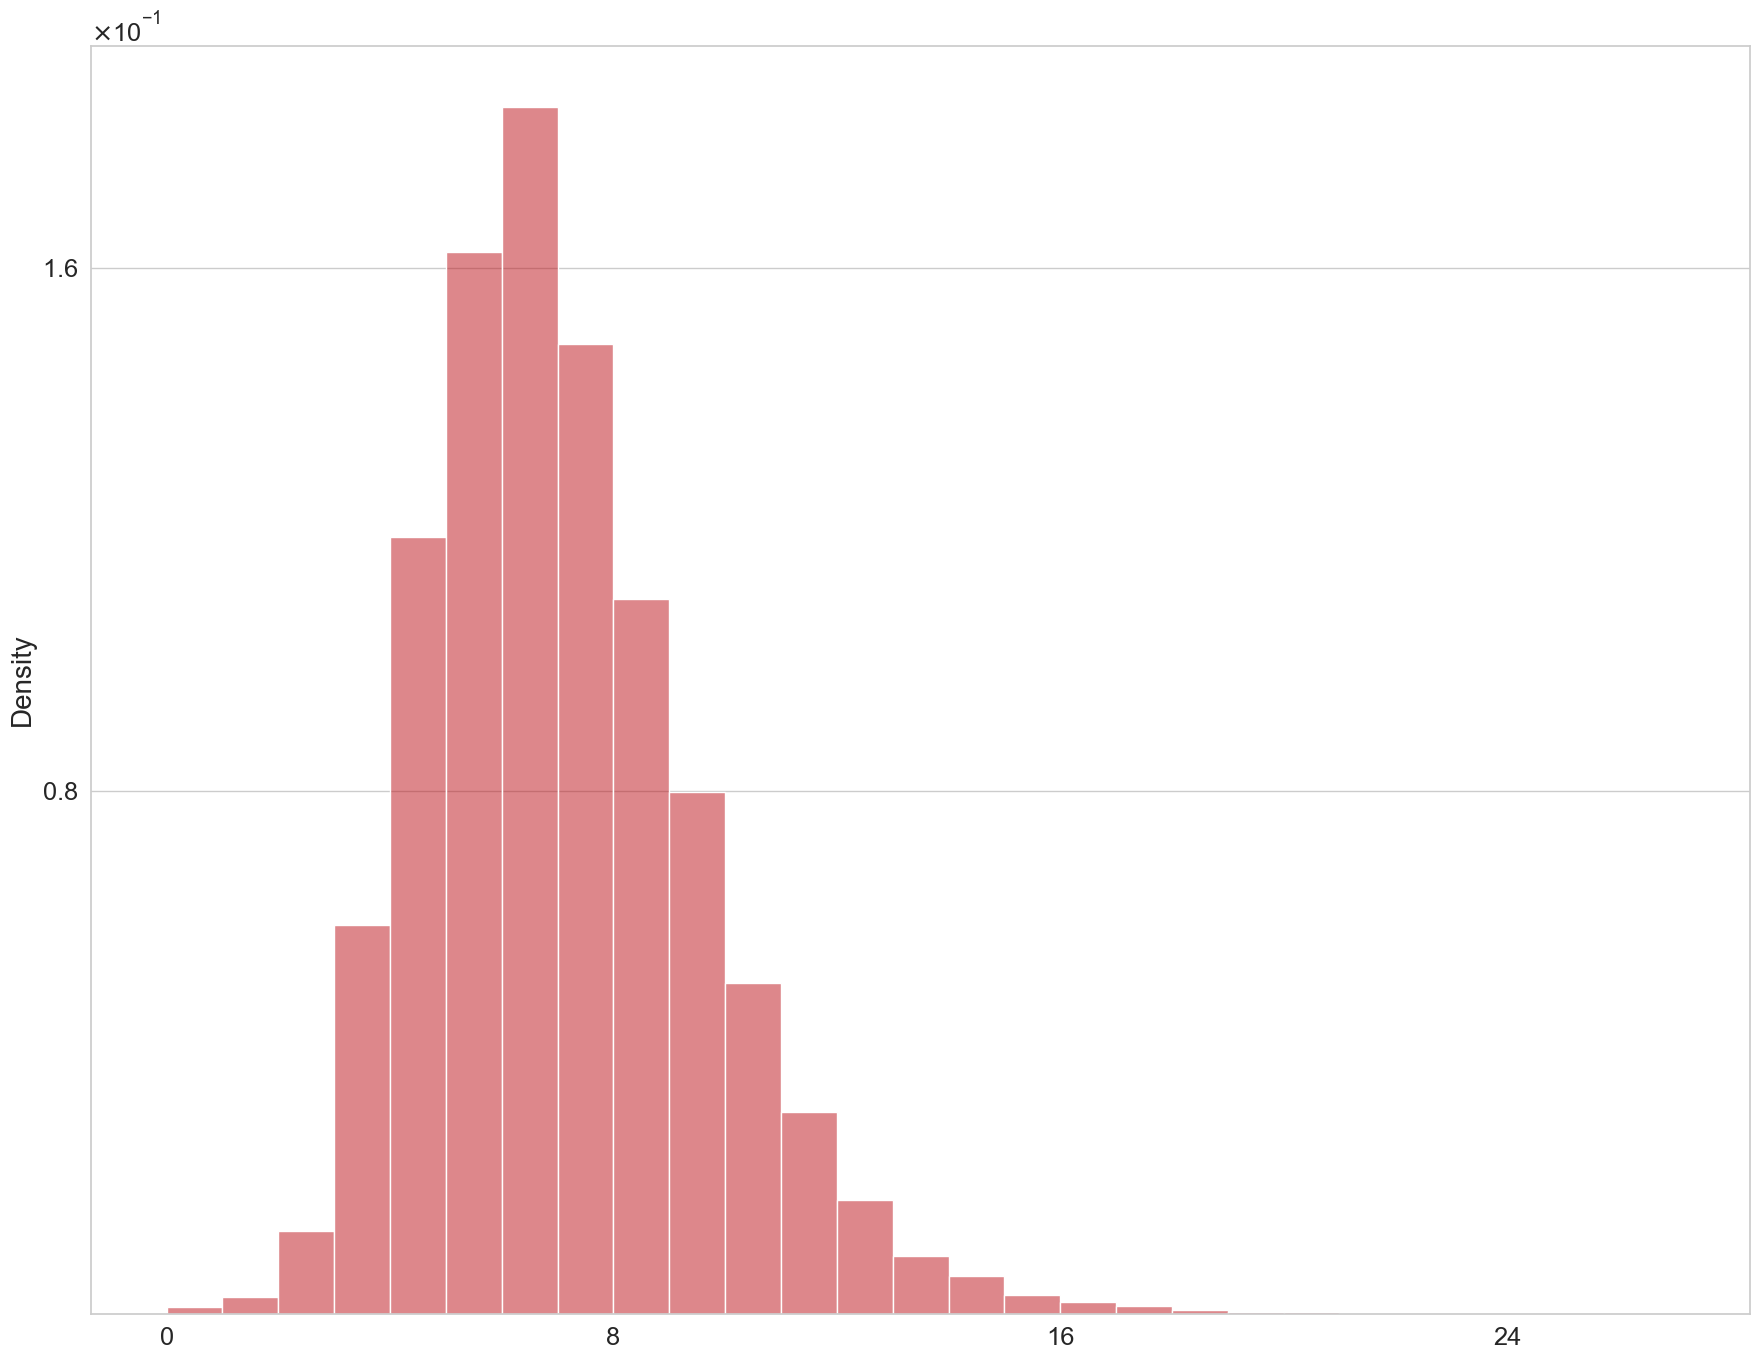

In [56]:
# Define a color for the histogram bars
EB_COLOR = "#bd1118"
# Set the font size for plotting
FONTSIZE = 20

def save_figure(fig, save_path: str = None) -> None:
    # If a save path is provided, save the figure to that path
    if save_path is not None:
        path = Path(save_path)  # Convert the save path to a Path object
        path.parent.mkdir(parents=True, exist_ok=True)  # Create any necessary directories
        fig.savefig(path, dpi=300)  # Save the figure with a resolution of 300 DPI

def plot_histogram(
    df: pl.DataFrame,  # Input DataFrame containing the data to plot
    column_name: str = None,  # Name of the column to plot
    stat: str = "density",  # Type of statistic to plot (e.g., density)
    save_path: str = None,  # Path to save the plot
    x_max: int = None,  # Maximum x-axis value
    y_max: int = None,  # Maximum y-axis value
    binwidth: int = None,  # Width of the bins for the histogram
    num_xticks: int = None,  # Number of ticks on the x-axis
    num_yticks: int = None,  # Number of ticks on the y-axis
    fontsize: int = 12,  # Font size for labels
    bins: int = "auto",  # Number of bins; default is automatic
) -> None:
    # Create a new figure and axes for the histogram
    fig, ax = plt.subplots(figsize=(18, 14))
    # Set the theme for the seaborn plot
    sns.set_theme(style="whitegrid", font_scale=fontsize / 12)
    
    # Create the histogram using seaborn
    sns.histplot(
        data=df,
        x=column_name,  # Column to be plotted on the x-axis
        color=EB_COLOR,  # Set the color of the histogram bars
        binwidth=binwidth,  # Set the bin width
        alpha=0.5,  # Set the transparency of the bars
        stat=stat,  # Set the statistic type for the histogram
        bins=bins,  # Set the number of bins
    )
    
    # Set x-axis limits if specified
    if x_max is not None:
        ax.set_xlim([0, x_max])
    # Set y-axis limits if specified
    if y_max is not None:
        ax.set_ylim([0, y_max])
    
    # Format y-axis labels for better readability
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
    # Set x-axis ticks
    ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=num_xticks))
    # Set y-axis ticks if specified
    if num_yticks is not None:
        ax.yaxis.set_major_locator(MaxNLocator(nbins=num_yticks, prune="lower"))

    # Add a grid to the x-axis
    plt.grid(axis="x")
    plt.title("")  # Clear the title
    plt.xlabel("")  # Clear the x-axis label
    plt.ylabel(stat.capitalize())  # Set the y-axis label based on the statistic
    plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))  # Format y-axis for scientific notation
    plt.tight_layout()  # Adjust the layout to fit all elements
    save_figure(fig, save_path=save_path)  # Save the figure using the save_figure function
    plt.show()  # Display the plot

# Call the plot_histogram function to plot the histogram for titles with word counts <= 18
plot_histogram(
    df_articles.filter(pl.col(N_WORDS_TITLE) <= 30).select(N_WORDS_TITLE),  # Filter and select the relevant data
    num_xticks=4,  # Set the number of x-ticks
    num_yticks=3,  # Set the number of y-ticks
    fontsize=FONTSIZE,  # Set the font size for the plot
    binwidth=1,  # Set the width of the histogram bins
    column_name=N_WORDS_TITLE,  # Specify the column to plot
    save_path=PLOT_PATH.joinpath(N_WORDS_TITLE + ".png"),  # Specify the save path for the plot
)


## Histogram of subtitle word count in df_article

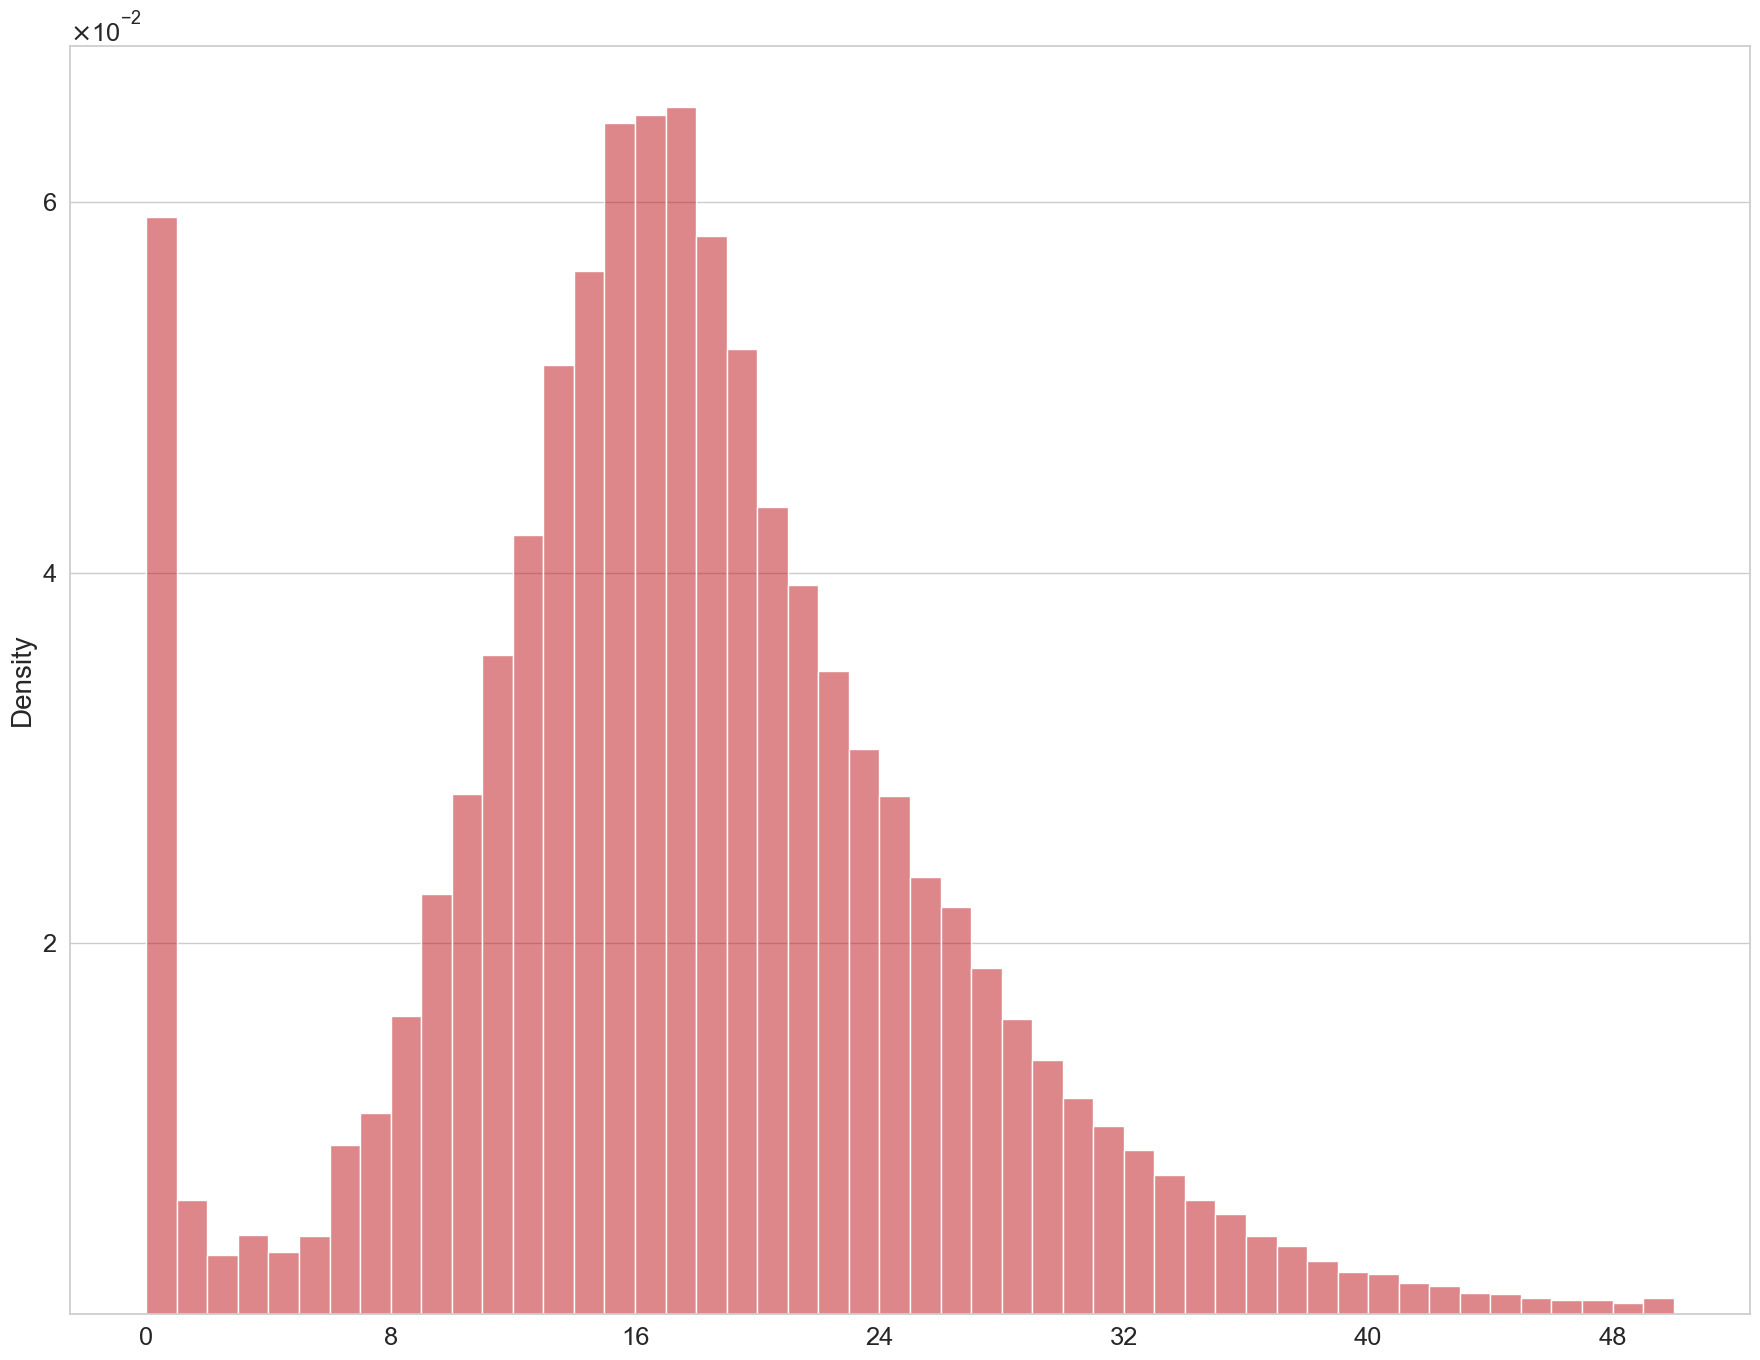

In [59]:
plot_histogram(
    df_articles.filter(pl.col(N_WORDS_SUBTITLE) <= 50).select(N_WORDS_SUBTITLE),
    num_xticks=8,
    num_yticks=4,
    fontsize=FONTSIZE,
    binwidth=1,
    column_name=N_WORDS_SUBTITLE,
    save_path=PLOT_PATH.joinpath(N_WORDS_SUBTITLE + ".png"),
)

## Histogram of Body text word count in df_article

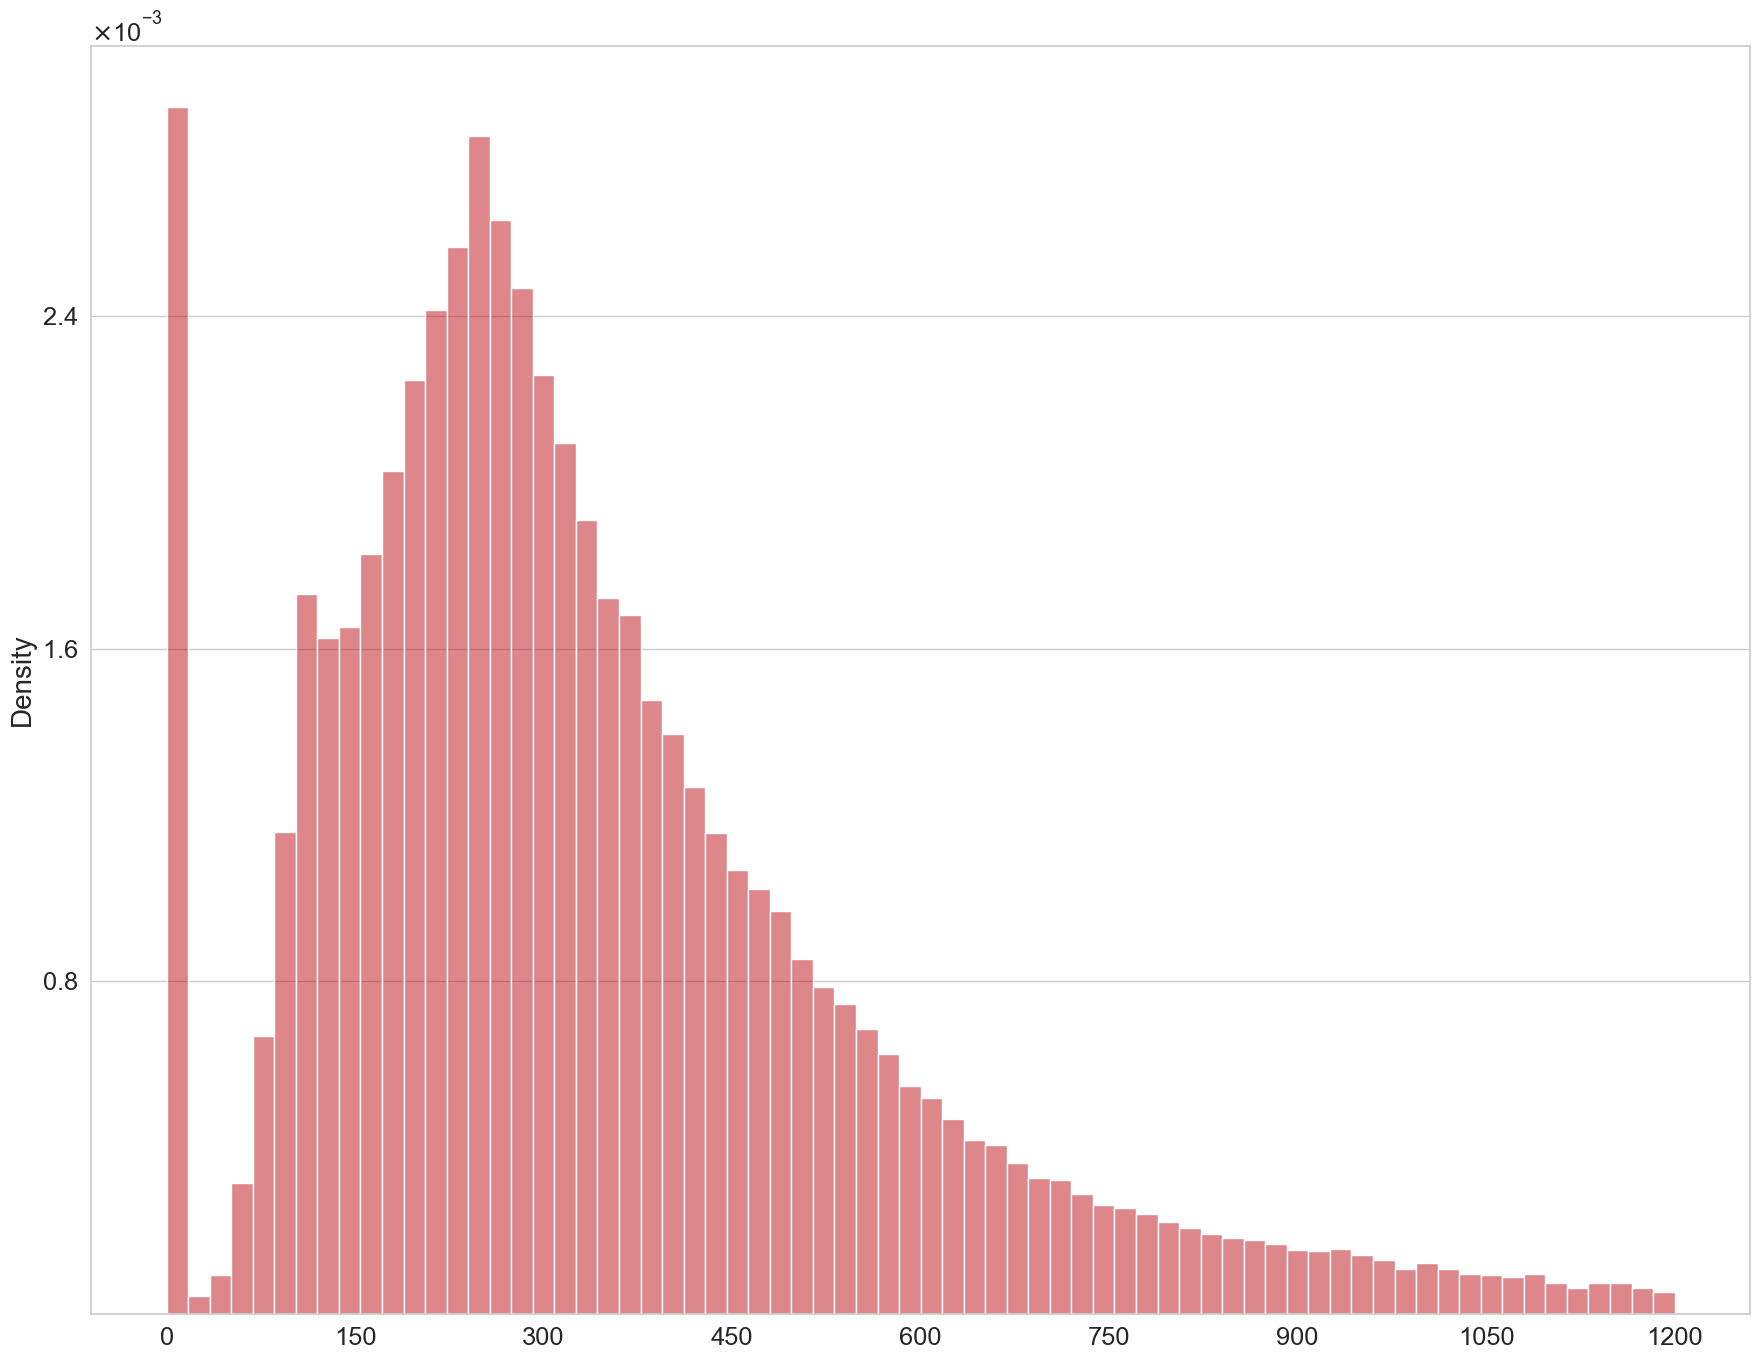

In [60]:
plot_histogram(
    df_articles.filter(pl.col(N_WORDS_BODY) <= 1200).select(N_WORDS_BODY),
    num_xticks=10,
    num_yticks=5,
    fontsize=FONTSIZE,
    bins=70,
    binwidth=None,
    column_name=N_WORDS_BODY,
    save_path=PLOT_PATH.joinpath(N_WORDS_BODY + ".png"),
)

## Note to histograms:

for subtitle word count and body word count wehave a lot of articles with very very little words in their word count... whats up with that?

In [65]:
DEFAULT_CATEGORY_STR_COL = "category_str"
df_articles[DEFAULT_CATEGORY_STR_COL].value_counts(sort=True).head(10)

category_str,count
str,u32
"""nyheder""",27876
"""underholdning""",24909
"""krimi""",22579
"""sport""",18767
"""side9""",4628
"""forbrug""",4328
"""sex_og_samliv""",4030
"""musik""",3641
"""auto""",3513


In [72]:
df_category = (
    df_articles[DEFAULT_CATEGORY_STR_COL]
    .value_counts(sort=True)
    .with_columns(pl.col("count") / pl.col("count").sum())
)
df_category.with_columns(pl.col("count").cum_sum().name.suffix("_cum_sum"))

# count column is the percentage of articles with given topic

# count_com_sum is the cumulative som of the percentages. So "nyheder" and "underholdning" makes up 42% of all the articles.



category_str,count,count_cum_sum
str,f64,f64
"""nyheder""",0.222047,0.222047
"""underholdning""",0.198413,0.42046
"""krimi""",0.179854,0.600314
"""sport""",0.149489,0.749803
"""side9""",0.036864,0.786667
…,…,…
"""podcast""",0.00004,0.999968
"""abonnement""",0.000008,0.999976
"""webmaster-test-sektion""",0.000008,0.999984
